## Setup

Extracting ./cs231n/datasets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\t10k-labels-idx1-ubyte.gz
c1 : 
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]

c2-1 : 
 [[ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]]

c2-2 : 
 [[ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]]


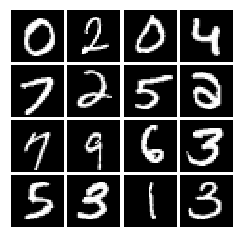

In [21]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images,c1,c2):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    cat_num = np.argwhere(c1 == 1.0)[:,1].reshape(sqrtn, sqrtn)
    conti1 = c2[:,0].reshape(sqrtn, sqrtn)
    conti2 = c2[:,1].reshape(sqrtn, sqrtn)
    
    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    
    np.set_printoptions(precision=2)
    print("c1 : \n", cat_num)
    print("")
    print("c2-1 : \n", conti1)
    print("")
    print("c2-2 : \n", conti2)

    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def leaky_relu(x, alpha=0.01):
    return alpha*tf.minimum(x,0.0)+tf.maximum(x,0.0)  

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0], np.eye(16), np.ones((16,2)))


## Generate noise

In [22]:
def sample_noise(batch_size, dim):
    return  np.random.uniform(size = (batch_size,dim), low = -1, high = 1)

def sample_c1(batch_size) :
    return np.random.multinomial(1,[0.1]*10,batch_size).astype(float)

def sample_c2(batch_size) :
    return np.random.uniform(size = (batch_size,2), low = -1, high = 1)

## Discriminator, Generator, conditional Prob expectator (Q_model)

conditional_q는 input(x or hidden)을 받으면 그에 해당하는 *c의 조건부 확률 분포*를 반환한다. 우리는 input으로 넣어준 c를 아므로 이에 해당하는 확률을 추출한뒤 mutual infomation을 계산할 수 있다.

conditional prob expectator는 x~G(z,c)로부터 (c,x)한 세트가 만들어 질때 p(c|x)를 증가시켜 조건부 분포와 가까워지도록 하고
generator는 p(c|x)가 큰 x를 만들도록 바뀐다. 

문제는 균형을 깨면 p(c|x)가 증가하고 이러한 x가 만들어지고 또 증가하고...되는데 균형이 안깨지면 c에 따라 x가 번갈아 나오면서 p(c|x)가 비슷해지고 generator도 변화가 서로 상쇄될 수 있다.

In [23]:
def discriminator(x, is_training = True):
    
    with tf.variable_scope("discriminator"):
        x_img = tf.reshape(x, [-1,28,28,1])
        with tf.variable_scope("conv1"):
            w1 = tf.get_variable("w1", shape = [4,4,1,64])
            b1 = tf.get_variable("b1", shape = [64], initializer = tf.constant_initializer(0))
            out11 = leaky_relu(tf.nn.conv2d(x_img,w1, strides = [1,2,2,1], padding = "SAME")+b1)
            
        with tf.variable_scope("conv2"):
            w2 = tf.get_variable('w2', shape = [4,4,64,128])
            out21 = tf.nn.conv2d(out11, w2, strides = [1,2,2,1], padding = 'SAME')
            out22 = tf.contrib.layers.batch_norm(out21,center = True, scale = True, epsilon = 1e-5, activation_fn = leaky_relu,
                                                is_training = is_training)
            out23 = tf.reshape(out22, [-1,7*7*128])
      
        with tf.variable_scope('fc1'):
            hidden = tf.contrib.layers.fully_connected(out23, num_outputs=1024, activation_fn = leaky_relu,
                                              normalizer_fn = tf.contrib.layers.batch_norm,
                                              normalizer_params = {'scale' : True, 'is_training' : is_training},
                                              biases_initializer = None)
        
        with tf.variable_scope('fc2'):
            w4 = tf.get_variable('w4', shape = [1024,1])
            b4 = tf.get_variable('b4', shape = [1],initializer = tf.constant_initializer(0))
            prob = tf.nn.sigmoid(tf.matmul(hidden,w4)+b4)
            
        return prob, hidden

def conditional_q(hidden, true_c1, true_c2, lamb = 1, lamb_conti = 0.1, is_training = True, eps = 1e-5):
    
    num_output = true_c1.shape[1] + true_c2.shape[1]#*2
    with tf.variable_scope("conditional_q") :
        with tf.variable_scope('fc1'):
            out = tf.contrib.layers.fully_connected(hidden, num_outputs=128, activation_fn = leaky_relu,
                                              normalizer_fn = tf.contrib.layers.batch_norm,
                                              normalizer_params = {'scale' : True, 'is_training' : is_training},
                                              biases_initializer = None)
        with tf.variable_scope('fc2'):
            w2 = tf.get_variable('w2', shape = [128, num_output])
            b2 = tf.get_variable('b2', shape = [num_output],initializer = tf.constant_initializer(0))
            cond = tf.matmul(out,w2)+b2

        cat_num = true_c1.shape[1]
    
        #cat conditional value
        cond_cat = tf.reduce_mean(tf.log(tf.reduce_sum(tf.nn.softmax(cond[:,:cat_num])*true_c1, axis = 1)+eps))
        
        '''
        conti_value1 = true_c2[:,0]
        conti_value2 = true_c2[:,1]

        #conti conditional value1
        mean = cond[:,cat_num:cat_num+1]
        std = tf.exp(cond[:,cat_num+1:cat_num+2])
        cond_conti = tf.reduce_mean(-1/2*tf.log(2*np.pi) - tf.log(std+eps) - 0.5*tf.square((conti_value1 - mean)/(std+eps)))
        
        #conti conditional value1
        mean2 = cond[:,cat_num+2:cat_num+3]
        std2 = tf.exp(cond[:,cat_num+3:cat_num+4])
        cond_conti2 = tf.reduce_mean(-1/2*tf.log(2*np.pi) - tf.log(std2+eps) - 0.5*tf.square((conti_value2 - mean2)/(std2+eps)))
        '''
        return -lamb*cond_cat#-lamb_conti*(cond_conti+cond_conti2)
        
def generator(z,is_training=True):

    batch_size = int(z.shape[0])
    with tf.variable_scope("generator"):
        with tf.variable_scope('fc1'):
            out11 = tf.contrib.layers.fully_connected(z,num_outputs=1024, activation_fn = tf.nn.relu,
                                              normalizer_fn = tf.contrib.layers.batch_norm,
                                              normalizer_params = {'scale' : True, 'is_training' : is_training},
                                              biases_initializer = None)
        with tf.variable_scope('fc2'):
            out21 = tf.contrib.layers.fully_connected(out11,num_outputs=7*7*128, activation_fn = tf.nn.relu,
                                              normalizer_fn = tf.contrib.layers.batch_norm,
                                              normalizer_params = {'scale' : True, 'is_training' : is_training},
                                              biases_initializer = None)
            out22 = tf.reshape(out21, [-1,7,7,128])
        with tf.variable_scope('convT1'):
            w3 = tf.get_variable("w3", shape = [4,4,64,128])
            out31 = tf.nn.relu(tf.nn.conv2d_transpose(value = out22, filter = w3, output_shape = [batch_size,14,14,64],
                                                      strides = [1,2,2,1], padding = 'SAME'))
        with tf.variable_scope('convT2'):    
            out41 = tf.contrib.layers.batch_norm(out31,center = True, scale = True, is_training = is_training)
            w4 = tf.get_variable("w4", shape = [4,4,1,64])
            b4 = tf.get_variable("b4", shape = [1])
            img = tf.tanh(tf.nn.conv2d_transpose(value = out41, filter = w4, output_shape = [batch_size,28,28,1],
                                                 strides = [1,2,2,1], padding = 'SAME')+b4)
        return img


## loss

In [24]:
def infogan_loss(logits_real, logits_fake):
    
    label_real = tf.ones_like(logits_real)
    label_fake = tf.zeros_like(logits_fake)
    
    D_loss = (tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = label_real, logits = logits_real))
             + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = label_fake, logits = logits_fake))
             )
    
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = 1-(label_fake), logits = logits_fake))
    
    return D_loss, G_loss

## Graph ( placeholder, loss, optimizer)

In [25]:
tf.reset_default_graph()

batch_size = 128
dim = 62

z = tf.placeholder(shape = (batch_size, dim), dtype = tf.float32)
c1 = tf.placeholder(shape = (batch_size,10), dtype = tf.float32)
c2 = tf.placeholder(shape = (batch_size,2), dtype = tf.float32)

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])

# generated images
G_sample = generator(tf.concat(axis = 1, values = [z,c1,c2]), is_training = False)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real,_ = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake, hidden  = discriminator(G_sample)

#optimizer
D_solver = tf.train.AdamOptimizer(learning_rate = 2e-4, beta1 = 0.5)
G_solver = tf.train.AdamOptimizer(learning_rate = 1e-3, beta1 = 0.5)
Q_solver = tf.train.AdamOptimizer(learning_rate = 2e-4, beta1 = 0.5)


# loss (each of losses should be minimized)
D_loss, G_loss = infogan_loss(logits_real, logits_fake)
Q_loss = conditional_q(hidden, c1, c2, lamb = 1, is_training = True)


# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 
Q_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conditional_q") 
print(D_vars)

D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')
Q_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'conditional_q')

# train_step
with tf.control_dependencies(D_extra_step):
    D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
with tf.control_dependencies(G_extra_step):
    G_train_step = G_solver.minimize(G_loss, var_list = G_vars)
    with tf.control_dependencies(Q_extra_step):
        Q_train_step = Q_solver.minimize(Q_loss, var_list = G_vars + Q_vars)



[<tf.Variable 'discriminator/conv1/w1:0' shape=(4, 4, 1, 64) dtype=float32_ref>, <tf.Variable 'discriminator/conv1/b1:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'discriminator/conv2/w2:0' shape=(4, 4, 64, 128) dtype=float32_ref>, <tf.Variable 'discriminator/conv2/BatchNorm/beta:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'discriminator/conv2/BatchNorm/gamma:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'discriminator/fc1/fully_connected/weights:0' shape=(6272, 1024) dtype=float32_ref>, <tf.Variable 'discriminator/fc1/fully_connected/BatchNorm/beta:0' shape=(1024,) dtype=float32_ref>, <tf.Variable 'discriminator/fc1/fully_connected/BatchNorm/gamma:0' shape=(1024,) dtype=float32_ref>, <tf.Variable 'discriminator/fc2/w4:0' shape=(1024, 1) dtype=float32_ref>, <tf.Variable 'discriminator/fc2/b4:0' shape=(1,) dtype=float32_ref>]


## Runner

In [7]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, Q_train_step,Q_loss,G_extra_step,D_extra_step,Q_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10, noise_dim = 62):
  
    G_loss_hist = []
    D_loss_hist = []
    Q_loss_hist = []
    
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    print("max iter : %d" %max_iter)
    
    for it in range(max_iter):
        
        #make noise, c
        noise_z = sample_noise(batch_size, noise_dim)
        sam_c1 = sample_c1(batch_size)
        sam_c2 = sample_c2(batch_size)
        
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample, feed_dict = {z : noise_z, c1 : sam_c1, c2 : sam_c2})
            fig = show_images(samples[:16], sam_c1[:16], sam_c2[:16])
            plt.show()
            print()
        
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)

        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch, z : noise_z, c1 : sam_c1, c2 : sam_c2})
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict = {z : noise_z, c1 : sam_c1, c2 : sam_c2})
        _, Q_loss_curr = sess.run([Q_train_step, Q_loss], feed_dict = {z : noise_z, c1 : sam_c1, c2 : sam_c2})

        G_loss_hist.append(G_loss_curr)
        D_loss_hist.append(D_loss_curr)
        Q_loss_hist.append(Q_loss_curr)
        
        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}, Q:{:.4}'.format(it,D_loss_curr,G_loss_curr,Q_loss_curr))
    
    print('Final images')
    samples = sess.run(G_sample, feed_dict = {z : noise_z, c1 : sam_c1, c2 : sam_c2})

    fig = show_images(samples[:16], sam_c1[:16], sam_c2[:16])
    plt.show()
    
    plt.plot(G_loss_hist, label= "G_loss_hist")
    plt.plot(D_loss_hist, label= "D_loss_hist")
    plt.plot(Q_loss_hist, label= "Q_loss_hist")
    plt.xlabel('iter')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

## Train & Save

max iter : 2148
c1 : 
 [[7 1 2 3]
 [2 0 0 4]
 [7 6 0 0]
 [3 4 4 8]]

c2-1 : 
 [[ 0.72976481  0.86427147 -0.20088203  0.44135804]
 [-0.56018437 -0.96415223  0.0058501  -0.47765206]
 [ 0.99027559 -0.64409553  0.17691682 -0.82075719]
 [-0.84699919 -0.3061021   0.16599507 -0.50327616]]

c2-2 : 
 [[ 0.21971756  0.14118916  0.5424269   0.46476651]
 [ 0.7543643   0.26769902  0.86700159  0.73559802]
 [-0.40443667 -0.59635231 -0.74538051  0.67041072]
 [-0.38987482 -0.48981    -0.67146063  0.5762506 ]]


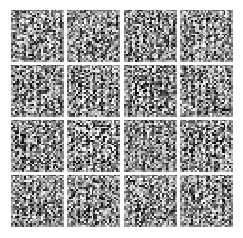


Iter: 0, D: 1.454, G:0.5413, Q:10.67
Iter: 50, D: 1.128, G:0.6711, Q:21.1
Iter: 100, D: 1.104, G:0.6823, Q:25.98
Iter: 150, D: 1.293, G:0.665, Q:14.48
Iter: 200, D: 1.304, G:0.6643, Q:8.2
c1 : 
 [[7 5 3 6]
 [9 1 5 0]
 [7 4 6 5]
 [7 6 6 1]]

c2-1 : 
 [[ 0.51960127 -0.97038008 -0.07628933 -0.59302566]
 [-0.68540062  0.13510475 -0.95294949 -0.90072972]
 [-0.01519775  0.61888186 -0.57153437  0.67211348]
 [-0.66095795  0.51528188 -0.04842332 -0.67075652]]

c2-2 : 
 [[ 0.59327191 -0.29563083 -0.66271618 -0.49352612]
 [ 0.62696215  0.06157801  0.36480685  0.6199655 ]
 [ 0.11477274 -0.42591371  0.61205662 -0.51088105]
 [-0.13301745 -0.83423243 -0.72514241  0.20998037]]


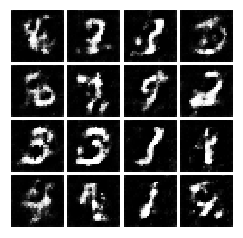


Iter: 250, D: 1.312, G:0.6609, Q:8.076
Iter: 300, D: 1.284, G:0.6592, Q:8.763
Iter: 350, D: 1.277, G:0.6614, Q:10.75
Iter: 400, D: 1.308, G:0.6584, Q:6.602
Iter: 450, D: 1.303, G:0.6592, Q:6.353
c1 : 
 [[5 2 6 6]
 [1 9 1 5]
 [3 5 1 8]
 [7 1 7 9]]

c2-1 : 
 [[-0.72855285  0.98960259 -0.07893994 -0.10203953]
 [ 0.2915657   0.74414371 -0.5461858   0.21875834]
 [-0.69012164  0.16526058  0.5758212   0.95812493]
 [ 0.33944862  0.92822249  0.36882907 -0.0935945 ]]

c2-2 : 
 [[ 0.53137896  0.12366135 -0.88228641  0.7659301 ]
 [-0.04059344  0.01504971  0.57697251  0.12371577]
 [-0.66585917  0.16847906  0.32093225 -0.07014419]
 [ 0.81719623 -0.68037861  0.83173244  0.84525363]]


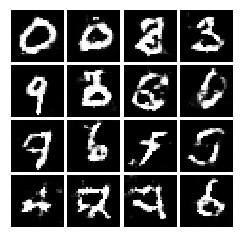


Iter: 500, D: 1.273, G:0.656, Q:6.759
Iter: 550, D: 1.271, G:0.6692, Q:8.066
Iter: 600, D: 1.246, G:0.6621, Q:6.868
Iter: 650, D: 1.267, G:0.6626, Q:6.316
Iter: 700, D: 1.245, G:0.6687, Q:7.214
c1 : 
 [[0 3 8 7]
 [7 0 9 2]
 [3 4 3 4]
 [3 2 2 1]]

c2-1 : 
 [[-0.32790015 -0.33624478 -0.17931007  0.97008582]
 [-0.33690897  0.58951987  0.10360578  0.52841458]
 [-0.62791979  0.71805861  0.76023754 -0.21629433]
 [-0.45287428  0.95351031 -0.46290501 -0.72498136]]

c2-2 : 
 [[ 0.34216167 -0.82120335 -0.2143281  -0.18848552]
 [-0.7772211   0.04946579  0.1037084  -0.72897837]
 [-0.47766106 -0.1494182  -0.11050305 -0.81843481]
 [-0.22230259 -0.52399769  0.75368189  0.72705966]]


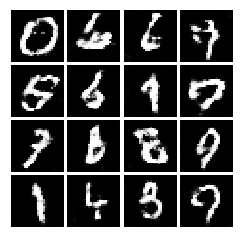


Iter: 750, D: 1.224, G:0.6695, Q:6.285
Iter: 800, D: 1.234, G:0.6635, Q:6.441
Iter: 850, D: 1.249, G:0.672, Q:6.483
Iter: 900, D: 1.246, G:0.6671, Q:7.263
Iter: 950, D: 1.227, G:0.6723, Q:6.129
c1 : 
 [[7 3 4 7]
 [5 1 0 2]
 [3 5 8 4]
 [5 7 2 2]]

c2-1 : 
 [[ 0.05408319 -0.67588385  0.52680394 -0.50747579]
 [ 0.82201866  0.01361699 -0.66380969  0.71699536]
 [ 0.64861322 -0.02118951 -0.81096439 -0.8403118 ]
 [ 0.64395116 -0.03647891  0.9935348   0.04063137]]

c2-2 : 
 [[-0.56263187  0.61877116 -0.78345062 -0.65080122]
 [-0.47453164  0.87663062 -0.54456472  0.42363455]
 [ 0.15313334 -0.98827113 -0.72535127 -0.75731239]
 [ 0.29765827  0.40745901  0.99094345  0.96194635]]


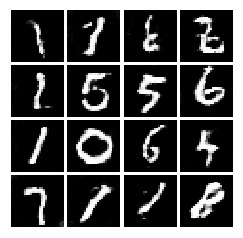


Iter: 1000, D: 1.225, G:0.6709, Q:6.227
Iter: 1050, D: 1.257, G:0.6646, Q:5.773
Iter: 1100, D: 1.23, G:0.6735, Q:5.904
Iter: 1150, D: 1.237, G:0.6759, Q:5.706
Iter: 1200, D: 1.225, G:0.6728, Q:5.668
c1 : 
 [[5 9 4 8]
 [2 3 2 4]
 [4 5 7 8]
 [9 6 5 4]]

c2-1 : 
 [[-0.17862487  0.23704975 -0.72850468 -0.73341542]
 [ 0.49225344 -0.91968394 -0.51793993 -0.48869758]
 [-0.57569494 -0.12305262 -0.3383639  -0.55359113]
 [ 0.88320768 -0.39609301 -0.06015665 -0.70073343]]

c2-2 : 
 [[-0.96881294 -0.18380821 -0.93409827 -0.99620286]
 [ 0.27400716 -0.3001641   0.243183   -0.43801532]
 [ 0.0848795  -0.38517177  0.75641672 -0.28240099]
 [-0.02453857  0.72397225 -0.09412705  0.0192658 ]]


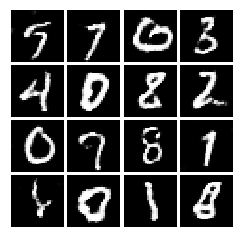


Iter: 1250, D: 1.234, G:0.6725, Q:5.762
Iter: 1300, D: 1.217, G:0.678, Q:6.714
Iter: 1350, D: 1.216, G:0.6742, Q:6.448
Iter: 1400, D: 1.256, G:0.676, Q:5.411
Iter: 1450, D: 1.235, G:0.6615, Q:5.54
c1 : 
 [[8 1 8 5]
 [2 6 2 9]
 [4 1 3 3]
 [2 1 6 2]]

c2-1 : 
 [[-0.5865238  -0.82509338  0.90454272 -0.23175862]
 [ 0.91726555 -0.51154847  0.27038438  0.4520539 ]
 [ 0.29989543  0.32011771 -0.29964917 -0.21484423]
 [ 0.52155304 -0.77087766  0.04357021 -0.55107606]]

c2-2 : 
 [[-0.56957224  0.59761396  0.45933117  0.86463734]
 [-0.93056875  0.31388816  0.72077157  0.54999519]
 [-0.62672128 -0.421533   -0.65289053 -0.08522396]
 [-0.59183811 -0.51654858  0.32564069  0.94122471]]


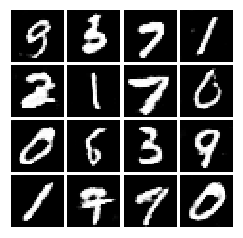


Iter: 1500, D: 1.241, G:0.6746, Q:5.618
Iter: 1550, D: 1.267, G:0.6739, Q:5.558
Iter: 1600, D: 1.224, G:0.6767, Q:5.827
Iter: 1650, D: 1.236, G:0.6769, Q:5.579
Iter: 1700, D: 1.184, G:0.6781, Q:5.791
c1 : 
 [[7 2 9 8]
 [8 5 1 4]
 [1 1 5 9]
 [6 4 3 4]]

c2-1 : 
 [[ 0.21028522 -0.55489352  0.2610458   0.50376267]
 [-0.44612317  0.44730665 -0.54476953 -0.30697317]
 [ 0.4186488  -0.43123228  0.70941499 -0.09078212]
 [-0.70191617 -0.19108974  0.47100231  0.53303426]]

c2-2 : 
 [[ 0.11997481 -0.89161827 -0.14497605 -0.90532122]
 [ 0.17161566 -0.27146179  0.18751827 -0.07747826]
 [ 0.68672259  0.39272117  0.66718257 -0.05513666]
 [-0.16854    -0.09628665 -0.87311793  0.86835766]]


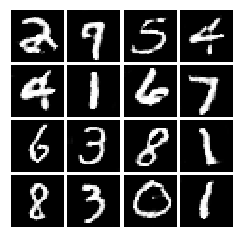


Iter: 1750, D: 1.219, G:0.6811, Q:5.433
Iter: 1800, D: 1.202, G:0.6712, Q:5.605
Iter: 1850, D: 1.237, G:0.6688, Q:5.115
Iter: 1900, D: 1.243, G:0.6799, Q:5.391
Iter: 1950, D: 1.207, G:0.6812, Q:5.451
c1 : 
 [[3 7 3 2]
 [6 9 6 9]
 [2 3 4 8]
 [1 3 0 6]]

c2-1 : 
 [[ 0.01248056 -0.71599576  0.20300115  0.91684079]
 [-0.53613956  0.23910937  0.44541868 -0.24660554]
 [-0.56320014 -0.44112613  0.82378488  0.24976028]
 [ 0.80936681  0.28772342  0.87783606  0.6020474 ]]

c2-2 : 
 [[-0.98188404  0.81390497 -0.19387193  0.85677885]
 [-0.50095896  0.65991561 -0.49066488  0.74835892]
 [-0.68572559 -0.23882119  0.41768269  0.44292083]
 [-0.99012313 -0.2420066  -0.57713577 -0.8802502 ]]


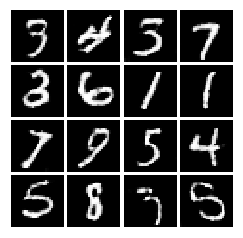


Iter: 2000, D: 1.251, G:0.674, Q:5.178
Iter: 2050, D: 1.225, G:0.666, Q:5.689
Iter: 2100, D: 1.214, G:0.6793, Q:5.793
Final images
c1 : 
 [[0 8 1 0]
 [3 8 2 4]
 [0 5 1 7]
 [7 0 1 8]]

c2-1 : 
 [[ 0.76916954 -0.92914213 -0.37721792  0.86144877]
 [-0.91576546 -0.88308539  0.07952345  0.08215295]
 [ 0.80060831  0.25537234  0.43050588  0.4445496 ]
 [ 0.13571222  0.29514915  0.96892984 -0.82122644]]

c2-2 : 
 [[ 0.95246103  0.37451063 -0.8570817   0.39560472]
 [ 0.06091792  0.08708043 -0.01479557  0.36097184]
 [ 0.60547394  0.35058421  0.12099973 -0.66006728]
 [-0.41008171 -0.84511934  0.95806733  0.2811534 ]]


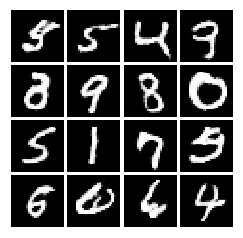

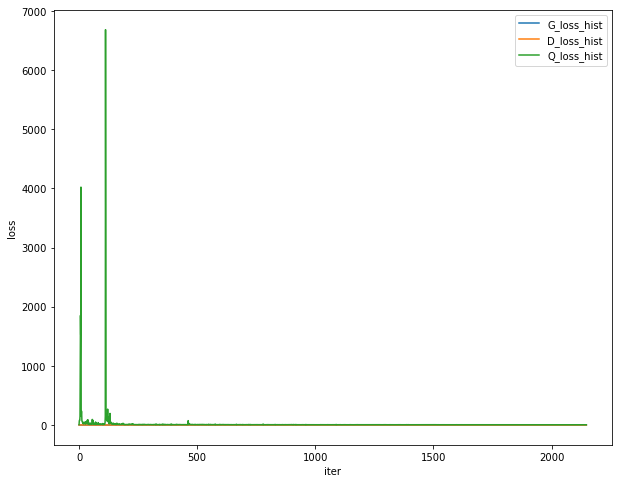

model saved in file C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN\infoGAN_ex.ckpt


In [188]:
saver = tf.train.Saver()

with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)
    save_path = saver.save(sess, r"C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN\infoGAN_ex.ckpt")
    print("model saved in file %s"%save_path)


## second

INFO:tensorflow:Restoring parameters from C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN\infoGAN_ex.ckpt
model retored
max iter : 2148
c1 : 
 [[5 4 6 7]
 [9 6 0 6]
 [5 3 9 0]
 [0 0 9 7]]

c2-1 : 
 [[ 0.81018027 -0.85619318 -0.64231858 -0.06175823]
 [-0.85854961  0.60441999 -0.26145394 -0.77319658]
 [-0.64333895 -0.20451981  0.30791375  0.94112192]
 [ 0.00239364 -0.90371613  0.09979851  0.22595858]]

c2-2 : 
 [[ 0.85945091  0.38992326  0.00990325  0.74052899]
 [ 0.40859449 -0.84696806 -0.84461729  0.28576448]
 [ 0.07187375  0.87352264 -0.47524457 -0.09090237]
 [ 0.85582321 -0.0672739   0.85206438 -0.18002058]]


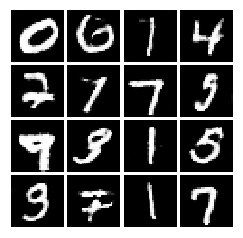


Iter: 0, D: 1.224, G:0.669, Q:5.256
Iter: 50, D: 1.226, G:0.6765, Q:5.321
Iter: 100, D: 1.244, G:0.6704, Q:5.313
Iter: 150, D: 1.203, G:0.6828, Q:5.284
Iter: 200, D: 1.227, G:0.6704, Q:5.418
c1 : 
 [[5 1 0 1]
 [2 2 8 2]
 [5 1 1 3]
 [2 4 9 0]]

c2-1 : 
 [[ 0.18730036  0.16212808 -0.82432539  0.50425778]
 [ 0.59351039 -0.19602917  0.38935969  0.9653374 ]
 [ 0.1876396   0.35912113 -0.80702352  0.81809988]
 [-0.29921514 -0.70893077  0.02808962  0.18912595]]

c2-2 : 
 [[ 0.55383271 -0.92961334 -0.97890852  0.90335564]
 [ 0.77840359 -0.56087015  0.93313121  0.82276768]
 [ 0.93663874  0.79486784  0.02208039 -0.44559657]
 [-0.48665293  0.75945621  0.98432166 -0.97570993]]


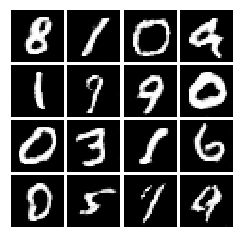


Iter: 250, D: 1.218, G:0.6755, Q:5.34
Iter: 300, D: 1.197, G:0.6811, Q:5.67
Iter: 350, D: 1.205, G:0.6757, Q:5.045
Iter: 400, D: 1.191, G:0.6828, Q:5.077
Iter: 450, D: 1.245, G:0.6788, Q:5.157
c1 : 
 [[5 0 3 6]
 [9 7 6 3]
 [0 5 0 2]
 [8 7 2 5]]

c2-1 : 
 [[ 0.49737562 -0.67925317 -0.52422263  0.09309831]
 [-0.10153774  0.2312271  -0.56891231  0.01152822]
 [-0.07714257  0.1480281   0.38036829 -0.86776111]
 [-0.80970009 -0.12516724  0.23422839  0.62474442]]

c2-2 : 
 [[ 0.53036381  0.44066787 -0.49002711  0.55773156]
 [-0.74643859 -0.84662387  0.53600099  0.50639713]
 [-0.15879053 -0.76913986 -0.12188761  0.34190551]
 [ 0.26012566  0.26095727  0.39983984 -0.74099626]]


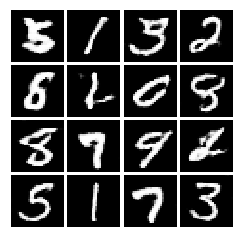


Iter: 500, D: 1.204, G:0.6844, Q:5.36
Iter: 550, D: 1.201, G:0.6779, Q:5.139
Iter: 600, D: 1.209, G:0.6845, Q:5.528
Iter: 650, D: 1.201, G:0.6811, Q:5.162
Iter: 700, D: 1.19, G:0.6801, Q:5.148
c1 : 
 [[4 3 2 9]
 [6 1 8 3]
 [1 5 3 7]
 [2 6 6 7]]

c2-1 : 
 [[-0.61299625  0.69456     0.49957527 -0.44777661]
 [-0.24264386  0.16784992  0.77366237 -0.54232417]
 [ 0.82493342 -0.95020446 -0.34875578 -0.14192946]
 [ 0.77966824  0.27347054  0.59759442  0.53088513]]

c2-2 : 
 [[ 0.62812195 -0.44749598 -0.72410281 -0.87431975]
 [ 0.54906946  0.84771429  0.14517955  0.25586269]
 [ 0.88260587 -0.57277947 -0.73501901  0.60639168]
 [ 0.58434056 -0.99393085 -0.78713016 -0.12413218]]


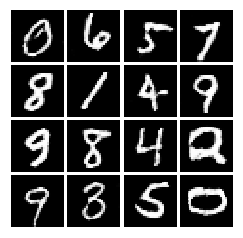


Iter: 750, D: 1.191, G:0.6754, Q:5.056
Iter: 800, D: 1.197, G:0.6779, Q:5.245
Iter: 850, D: 1.19, G:0.6835, Q:5.075
Iter: 900, D: 1.217, G:0.6731, Q:5.087
Iter: 950, D: 1.187, G:0.6841, Q:5.152
c1 : 
 [[2 6 0 8]
 [2 4 9 3]
 [5 6 7 2]
 [1 2 0 5]]

c2-1 : 
 [[-0.39638298  0.00285654 -0.69371415 -0.99217085]
 [-0.62209193  0.75727469  0.07470452 -0.54778563]
 [ 0.45973308 -0.33061932  0.63345804  0.77045943]
 [-0.82548409 -0.88424172 -0.44455315 -0.81050249]]

c2-2 : 
 [[ 0.64849409 -0.5562631  -0.21835657  0.41379189]
 [ 0.26195206  0.48872545 -0.59972239 -0.77055659]
 [-0.65877608  0.2562745   0.61459975  0.24677123]
 [ 0.94755546 -0.26403677  0.25050797 -0.19994507]]


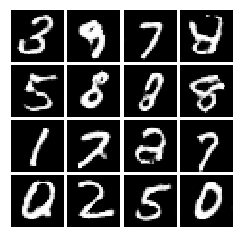


Iter: 1000, D: 1.202, G:0.6729, Q:4.944
Iter: 1050, D: 1.202, G:0.6756, Q:5.145
Iter: 1100, D: 1.18, G:0.6808, Q:5.054
Iter: 1150, D: 1.206, G:0.6828, Q:5.052
Iter: 1200, D: 1.2, G:0.6705, Q:5.194
c1 : 
 [[3 2 4 4]
 [6 4 3 3]
 [3 7 2 8]
 [7 2 1 0]]

c2-1 : 
 [[ 0.72424712  0.65888429 -0.28988622  0.00963454]
 [-0.86811632 -0.17586037  0.96027756  0.32270911]
 [-0.92726364  0.86331623 -0.70633889  0.16481693]
 [ 0.92715937  0.75885849 -0.58051949 -0.47948744]]

c2-2 : 
 [[-0.392431    0.3608312   0.77956939 -0.01847203]
 [ 0.19727906 -0.39137385 -0.2842836  -0.1674351 ]
 [ 0.62611792 -0.35306376  0.54916484 -0.96466466]
 [ 0.45964079  0.16181721  0.02224608 -0.04498627]]


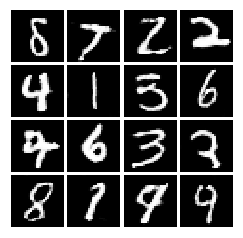


Iter: 1250, D: 1.161, G:0.688, Q:5.14
Iter: 1300, D: 1.176, G:0.6829, Q:5.319
Iter: 1350, D: 1.154, G:0.6848, Q:5.041
Iter: 1400, D: 1.16, G:0.6874, Q:4.962
Iter: 1450, D: 1.169, G:0.6809, Q:4.969
c1 : 
 [[4 6 9 8]
 [6 4 2 9]
 [4 1 5 3]
 [6 9 6 8]]

c2-1 : 
 [[-0.09235236 -0.40615291  0.1097039   0.09342307]
 [ 0.03396167 -0.99639924  0.58971377 -0.51113374]
 [-0.92646536 -0.57747874  0.11204449  0.14616697]
 [-0.63780531  0.21075099  0.94945938  0.46240098]]

c2-2 : 
 [[-0.55843052  0.47640957 -0.04043642  0.41971852]
 [ 0.0276075   0.24807008  0.12097618 -0.74766076]
 [ 0.44588075 -0.97158993  0.41579109  0.74580352]
 [-0.44869451 -0.05123716  0.89830517  0.13191883]]


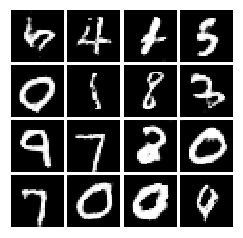


Iter: 1500, D: 1.191, G:0.6866, Q:4.894
Iter: 1550, D: 1.179, G:0.6842, Q:4.91
Iter: 1600, D: 1.19, G:0.6843, Q:4.785
Iter: 1650, D: 1.16, G:0.6737, Q:5.026
Iter: 1700, D: 1.157, G:0.6898, Q:4.834
c1 : 
 [[5 3 5 0]
 [3 2 3 1]
 [2 3 9 3]
 [6 7 2 9]]

c2-1 : 
 [[-0.02178102  0.72012667 -0.63213349  0.36959177]
 [ 0.33884026 -0.3903628   0.53500243  0.46997864]
 [-0.78236059  0.29192395  0.12484801 -0.24696879]
 [-0.12292684  0.06667305 -0.27855021  0.15949778]]

c2-2 : 
 [[-0.64537844 -0.09545773 -0.20189919 -0.73553921]
 [ 0.04856239 -0.9943453  -0.70294316 -0.70711086]
 [ 0.76157999  0.26367222 -0.18853798  0.14788027]
 [-0.0203234  -0.82788336 -0.20069239 -0.6770525 ]]


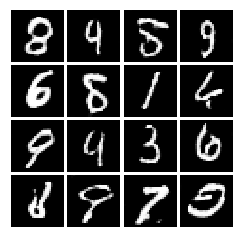


Iter: 1750, D: 1.143, G:0.6847, Q:4.961
Iter: 1800, D: 1.154, G:0.6899, Q:4.94
Iter: 1850, D: 1.182, G:0.6855, Q:5.037
Iter: 1900, D: 1.174, G:0.6628, Q:4.898
Iter: 1950, D: 1.171, G:0.6891, Q:5.063
c1 : 
 [[8 9 2 6]
 [5 8 5 7]
 [1 2 7 4]
 [5 6 4 0]]

c2-1 : 
 [[-0.14254044 -0.8386099  -0.34068575 -0.83524278]
 [-0.44949458 -0.80351713 -0.22031942  0.21865007]
 [ 0.59464523  0.49202435  0.70416245  0.31669468]
 [-0.66655813  0.06598744 -0.33088702 -0.26588759]]

c2-2 : 
 [[-0.05058933 -0.20592304  0.85076572 -0.46905605]
 [-0.27734473  0.73987591 -0.17373163 -0.31197402]
 [-0.28702667 -0.97926565  0.24190179 -0.10689408]
 [ 0.02995694  0.13584526 -0.52778028 -0.61975862]]


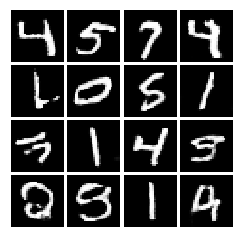


Iter: 2000, D: 1.171, G:0.6737, Q:4.806
Iter: 2050, D: 1.15, G:0.6843, Q:4.828
Iter: 2100, D: 1.171, G:0.6824, Q:4.952
Final images
c1 : 
 [[1 7 9 2]
 [9 5 2 6]
 [4 2 0 8]
 [4 7 0 2]]

c2-1 : 
 [[-0.02958946  0.65208068  0.39558522  0.0134706 ]
 [-0.65395498 -0.62682669  0.37407962  0.26253697]
 [-0.5971882   0.33366222 -0.9105512   0.24931707]
 [ 0.50586207 -0.8405891  -0.99608244 -0.57574117]]

c2-2 : 
 [[ 0.26178825 -0.9925685  -0.48200777 -0.63289522]
 [-0.58928957  0.05724013  0.80934298  0.65633491]
 [-0.36492808 -0.77522733 -0.43684607 -0.04145439]
 [ 0.54365212  0.95907233  0.46677998  0.67401912]]


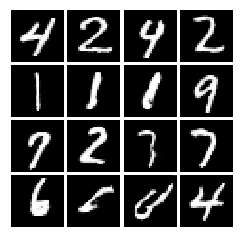

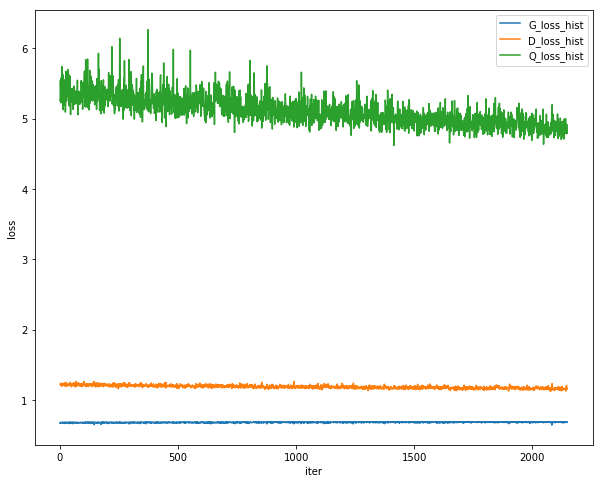

model saved in file C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN\infoGAN_ex2.ckpt


In [194]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, r"C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN\infoGAN_ex1.ckpt")
    print("model retored")    
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)
    save_path = saver.save(sess, r"C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN\infoGAN_ex2.ckpt")
    print("model saved in file %s"%save_path)


## third (change Q learning rate)

INFO:tensorflow:Restoring parameters from C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN\infoGAN_ex2.ckpt
model retored
max iter : 429
c1 : 
 [[5 6 0 6]
 [3 7 0 4]
 [7 0 9 2]
 [0 5 9 9]]

c2-1 : 
 [[-0.72524782  0.67160444 -0.04973714  0.21318643]
 [-0.90334371 -0.64531665  0.87762369 -0.77929267]
 [-0.25645655 -0.4054937  -0.22372505 -0.32824281]
 [-0.71264455  0.91600354 -0.49900199 -0.25233598]]

c2-2 : 
 [[ 0.14615551  0.84453278 -0.21154313  0.12606406]
 [ 0.28406207 -0.81112181  0.40299421  0.496021  ]
 [-0.59156535  0.21175906 -0.39895498 -0.23282948]
 [ 0.76400354 -0.82289689 -0.11493272 -0.80627142]]


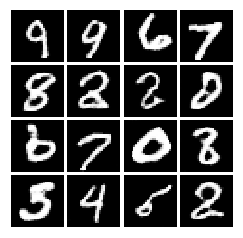


Iter: 0, D: 1.131, G:0.688, Q:4.766
Iter: 50, D: 1.184, G:0.6751, Q:4.928
Iter: 100, D: 1.179, G:0.6892, Q:4.756
Iter: 150, D: 1.182, G:0.6822, Q:4.702
Iter: 200, D: 1.153, G:0.6894, Q:4.786
c1 : 
 [[7 8 8 9]
 [0 6 9 4]
 [6 5 2 0]
 [3 7 9 2]]

c2-1 : 
 [[-0.62769185 -0.36225979  0.04816587 -0.15664108]
 [ 0.91660177 -0.23656516 -0.39818771  0.81866049]
 [ 0.50552798 -0.44389053 -0.5366265   0.2094148 ]
 [-0.61653981  0.10255442  0.24455184 -0.33558718]]

c2-2 : 
 [[-0.22683091 -0.83152291 -0.60937119  0.46881454]
 [ 0.63441256  0.50667936  0.02713017 -0.88554008]
 [ 0.93001035 -0.13743382 -0.19378527 -0.03468125]
 [-0.77014079  0.3039062   0.42270974  0.88341644]]


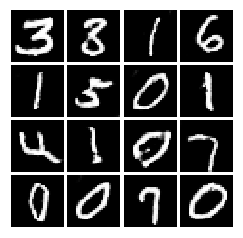


Iter: 250, D: 1.165, G:0.6886, Q:4.632
Iter: 300, D: 1.165, G:0.683, Q:4.617
Iter: 350, D: 1.147, G:0.6901, Q:4.597
Iter: 400, D: 1.151, G:0.6778, Q:4.579
Final images
c1 : 
 [[1 9 3 8]
 [4 7 3 7]
 [4 6 2 6]
 [2 0 4 4]]

c2-1 : 
 [[ 0.68688679 -0.8802919  -0.44664156  0.11611122]
 [ 0.06226268 -0.7905459   0.310617    0.08385981]
 [ 0.57718216 -0.50959599 -0.88148459 -0.88172846]
 [-0.42303562  0.62069997 -0.00379503 -0.77123194]]

c2-2 : 
 [[-0.30976026 -0.6282269  -0.6067367   0.53097332]
 [ 0.25667794  0.44575693 -0.44101765  0.89930935]
 [-0.85213045  0.02938952 -0.55660763  0.19236087]
 [ 0.29779438 -0.32786802  0.094207    0.75475972]]


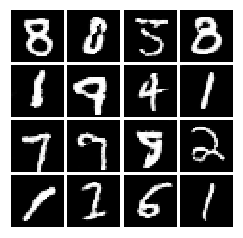

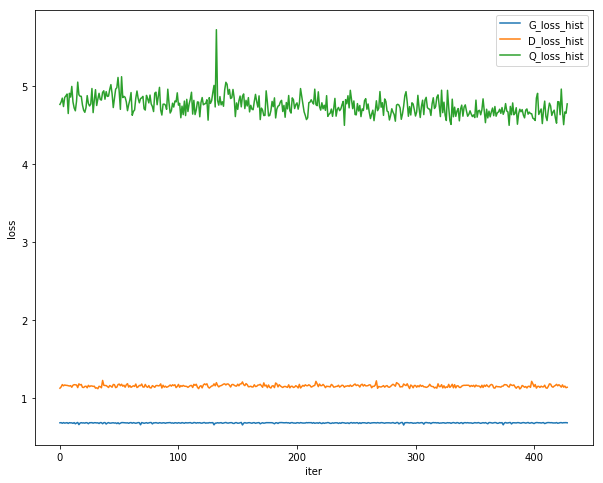

model saved in file C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN\infoGAN_ex3.ckpt


In [204]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, r"C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN\infoGAN_ex2.ckpt")
    print("model retored")
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=1)
    save_path = saver.save(sess, r"C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN\infoGAN_ex3.ckpt")
    print("model saved in file %s"%save_path)



## forth (make generator to minimize G_loss+Q_loss)

max iter : 859
c1 : 
 [[4 2 7 7]
 [9 1 1 7]
 [5 0 1 8]
 [9 0 2 5]]

c2-1 : 
 [[ 0.04796541 -0.33821303  0.90128497 -0.71243129]
 [-0.18696215 -0.05817376 -0.0189531   0.05623003]
 [ 0.09540407 -0.16338725  0.75825958 -0.18944272]
 [ 0.40638945  0.27475178  0.89328291  0.8565154 ]]

c2-2 : 
 [[-0.28999023  0.28667133  0.93298913  0.10088589]
 [-0.03853473 -0.10485909  0.1965074  -0.43451455]
 [ 0.61236341 -0.75349693  0.57354142  0.17895176]
 [-0.86573686  0.22354299 -0.83007884  0.03409823]]


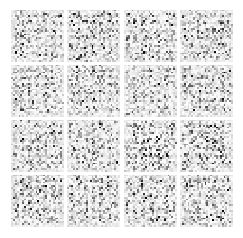


Iter: 0, D: 1.44, G:0.5598, Q:3.178
Iter: 50, D: 1.139, G:0.6773, Q:1.458
c1 : 
 [[1 0 1 6]
 [0 4 6 3]
 [6 3 3 7]
 [5 2 3 7]]

c2-1 : 
 [[ 0.74933616  0.57277041  0.82691152 -0.15631602]
 [ 0.73136334  0.64228303  0.85788411  0.03258245]
 [-0.82009664 -0.05794364  0.9094811   0.73396267]
 [ 0.78180022  0.3012283   0.34226449 -0.38354572]]

c2-2 : 
 [[-0.7263868  -0.43071668 -0.44972863  0.69447832]
 [ 0.02221813 -0.20853134 -0.21124131  0.90016918]
 [ 0.56868813 -0.71262935  0.20467549 -0.18869522]
 [-0.03977739  0.98529396  0.29166241  0.50506519]]


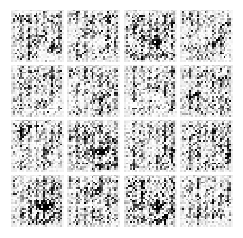


Iter: 100, D: 1.122, G:0.6851, Q:0.7404
Iter: 150, D: 1.094, G:0.6882, Q:0.5466
c1 : 
 [[5 2 0 0]
 [5 1 5 1]
 [4 2 4 0]
 [7 8 0 7]]

c2-1 : 
 [[-0.17510944 -0.52571015 -0.96720566 -0.56865237]
 [ 0.79907258  0.80873065 -0.59233113  0.89519787]
 [-0.20204103  0.34212911  0.3687419  -0.94131599]
 [ 0.70163075  0.20266832 -0.09173184 -0.43380865]]

c2-2 : 
 [[ 0.18465147  0.47777224  0.54601002  0.36062683]
 [-0.78749904  0.68136074  0.47088155 -0.2166506 ]
 [-0.12811106  0.11929075  0.53341416 -0.08045863]
 [ 0.54309675  0.95419505  0.94337687  0.20874089]]


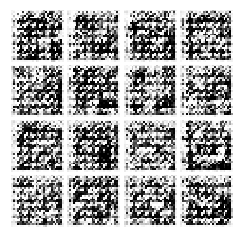


Iter: 200, D: 1.079, G:0.6871, Q:0.6152
Iter: 250, D: 1.089, G:0.6893, Q:0.8368
c1 : 
 [[6 4 7 7]
 [0 7 3 0]
 [4 7 4 7]
 [4 5 4 1]]

c2-1 : 
 [[ 0.87472199  0.64668955  0.95530421  0.23430599]
 [-0.94695857 -0.85508833 -0.05766505 -0.51950683]
 [ 0.1869356  -0.45428195  0.66692057  0.68394761]
 [ 0.24879329  0.87230756 -0.32313735 -0.93156826]]

c2-2 : 
 [[ 0.80842632 -0.51776961  0.8041532  -0.55322627]
 [ 0.99839948 -0.5380824   0.3665249  -0.97419791]
 [-0.44079611  0.193445    0.23294875  0.99925962]
 [ 0.18128806  0.09323844 -0.17657393  0.15048239]]


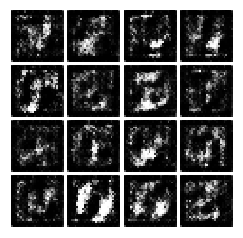


Iter: 300, D: 1.198, G:0.6782, Q:1.529
Iter: 350, D: 1.273, G:0.6676, Q:2.025
c1 : 
 [[4 7 0 8]
 [4 1 1 6]
 [8 2 3 2]
 [1 1 6 0]]

c2-1 : 
 [[-0.75259657 -0.8296414   0.83133243  0.75458192]
 [-0.90951531  0.7548088   0.82152582 -0.72687928]
 [ 0.81083905  0.96735292 -0.46743491 -0.72814255]
 [ 0.3063282  -0.26942533  0.76121257  0.40490935]]

c2-2 : 
 [[ 0.40581817 -0.70745105 -0.42974919  0.89898657]
 [ 0.61520444 -0.34668307 -0.30294198 -0.03806334]
 [ 0.02318265  0.00229006 -0.96999428 -0.2604441 ]
 [-0.9369376  -0.41410005 -0.64856     0.9948025 ]]


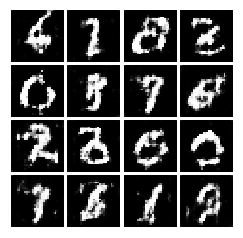


Iter: 400, D: 1.265, G:0.6627, Q:2.039
Iter: 450, D: 1.29, G:0.6648, Q:1.719
c1 : 
 [[8 2 8 4]
 [8 0 9 5]
 [9 9 7 2]
 [6 8 7 6]]

c2-1 : 
 [[-0.46377892  0.58120947 -0.0780185  -0.76759831]
 [ 0.49887553 -0.78087468 -0.33533758  0.64674988]
 [ 0.49312542  0.0240384  -0.24506892  0.65930897]
 [-0.54366983  0.70704408 -0.13834739 -0.22823533]]

c2-2 : 
 [[ 0.7760383   0.62817191 -0.57176676  0.84466135]
 [ 0.39835599  0.96029322  0.67826513 -0.08444867]
 [ 0.74567496 -0.16010879 -0.4572951   0.64605277]
 [-0.26732981  0.23787636  0.50662917  0.62271379]]


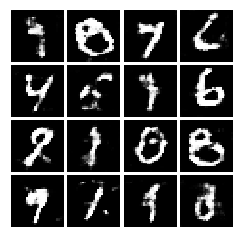


Iter: 500, D: 1.295, G:0.6692, Q:1.474
Iter: 550, D: 1.267, G:0.6678, Q:1.361
c1 : 
 [[3 3 3 2]
 [0 5 4 6]
 [9 6 5 8]
 [7 2 4 2]]

c2-1 : 
 [[ 0.27179996  0.43989607  0.71517327  0.10834861]
 [-0.58589932  0.37605255  0.96769733  0.56303735]
 [-0.64690767 -0.87329178 -0.08211502  0.50064087]
 [ 0.30134032 -0.69909999  0.48173286  0.40510085]]

c2-2 : 
 [[-0.62558323 -0.61615606  0.55636283 -0.93808531]
 [-0.0626639  -0.69136294  0.36185367 -0.87048962]
 [-0.91725324 -0.50945748  0.28471956  0.32765453]
 [ 0.32370692 -0.24056083 -0.09668006  0.0080927 ]]


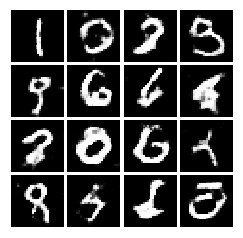


Iter: 600, D: 1.27, G:0.6557, Q:1.242
Iter: 650, D: 1.241, G:0.663, Q:1.265
c1 : 
 [[2 0 4 2]
 [0 3 4 9]
 [0 4 7 4]
 [5 7 8 6]]

c2-1 : 
 [[-0.63093069 -0.05744267 -0.96695107 -0.3370579 ]
 [-0.6121283   0.41427823 -0.45661487  0.61230935]
 [ 0.19087705  0.17088517  0.81188998  0.42929133]
 [ 0.81256906 -0.97708618 -0.19000591 -0.52367273]]

c2-2 : 
 [[-0.08544478 -0.96510601 -0.44248247  0.13190376]
 [-0.70723568 -0.74603849  0.87960836 -0.11425357]
 [-0.91851654 -0.00537442 -0.10952155 -0.11044588]
 [ 0.49759616  0.83756402 -0.50411098 -0.48170963]]


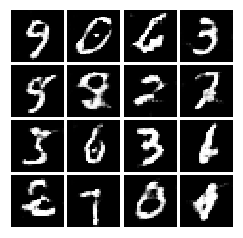


Iter: 700, D: 1.242, G:0.6498, Q:1.091
Iter: 750, D: 1.238, G:0.6691, Q:0.8956
c1 : 
 [[3 1 3 3]
 [6 9 1 7]
 [6 4 1 3]
 [6 5 3 9]]

c2-1 : 
 [[-0.46238235  0.69814056 -0.89721194 -0.49815472]
 [ 0.49402585 -0.48660903 -0.63666682  0.66439036]
 [-0.9450557  -0.10375773  0.50840403  0.98181596]
 [ 0.78689436  0.41847127 -0.08016407 -0.44224921]]

c2-2 : 
 [[ 0.95692186 -0.54489229 -0.62666565  0.82432243]
 [ 0.44175628 -0.70876092  0.4084552  -0.55400808]
 [ 0.413236    0.8615492   0.07671958  0.59033077]
 [-0.10757383  0.49705418  0.63877021 -0.53472454]]


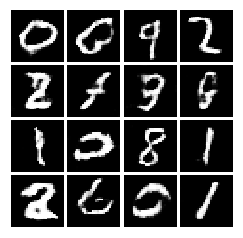


Iter: 800, D: 1.251, G:0.6625, Q:0.9708
Iter: 850, D: 1.243, G:0.6472, Q:1.03
Final images
c1 : 
 [[6 9 9 3]
 [6 6 5 2]
 [7 3 4 7]
 [3 8 7 7]]

c2-1 : 
 [[-0.24697912 -0.93975116  0.24139726 -0.88694424]
 [ 0.65432441  0.0733841   0.96943224 -0.01437219]
 [ 0.60877658 -0.64576497 -0.08841213  0.95557316]
 [ 0.84450451  0.65908821  0.84046509  0.28684562]]

c2-2 : 
 [[-0.78712607 -0.31379441 -0.24830709  0.13201723]
 [ 0.77021465 -0.76316428 -0.6173806  -0.60722358]
 [ 0.32367203 -0.06348865  0.94106823 -0.53909186]
 [-0.87940803  0.92462502 -0.61421962  0.75050147]]


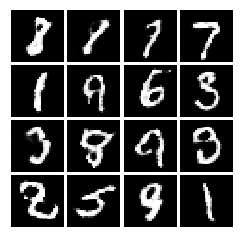

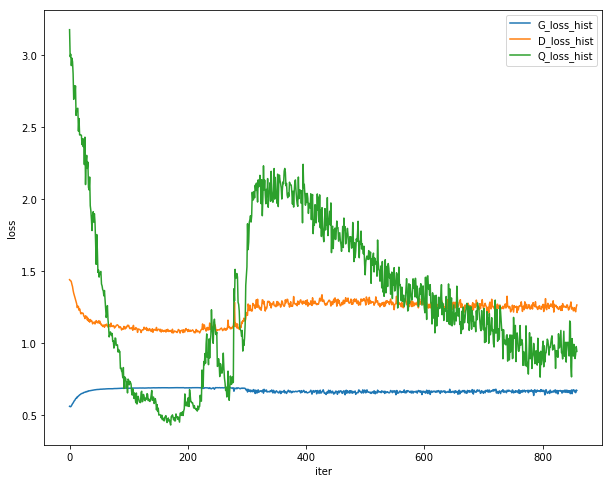

model saved in file C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN_real\infoGAN_ex.ckpt


In [234]:
saver = tf.train.Saver()

with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=2, show_every=100)
    save_path = saver.save(sess, r"C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN_real\infoGAN_ex.ckpt")
    print("model saved in file %s"%save_path)


In [9]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, r"C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN_real\infoGAN_ex.ckpt")
    print("model retored")
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5, show_every = 125)
    save_path = saver.save(sess, r"C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN_real\infoGAN_ex2.ckpt")
    print("model saved in file %s"%save_path)



INFO:tensorflow:Restoring parameters from C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN_real\infoGAN_ex.ckpt


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [128,12] rhs shape= [128,14]
	 [[Node: save_1/Assign_20 = Assign[T=DT_FLOAT, _class=["loc:@conditional_q/fc2/w2"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](conditional_q/fc2/w2, save_1/RestoreV2_20)]]

Caused by op 'save_1/Assign_20', defined at:
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-4801487f4109>", line 1, in <module>
    saver = tf.train.Saver()
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\tensorflow\python\training\saver.py", line 1139, in __init__
    self.build()
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\tensorflow\python\training\saver.py", line 1170, in build
    restore_sequentially=self._restore_sequentially)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\tensorflow\python\training\saver.py", line 691, in build
    restore_sequentially, reshape)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\tensorflow\python\training\saver.py", line 419, in _AddRestoreOps
    assign_ops.append(saveable.restore(tensors, shapes))
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\tensorflow\python\training\saver.py", line 155, in restore
    self.op.get_shape().is_fully_defined())
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\tensorflow\python\ops\state_ops.py", line 271, in assign
    validate_shape=validate_shape)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 45, in assign
    use_locking=use_locking, name=name)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\LG\AppData\Local\conda\conda\envs\py35\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [128,12] rhs shape= [128,14]
	 [[Node: save_1/Assign_20 = Assign[T=DT_FLOAT, _class=["loc:@conditional_q/fc2/w2"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](conditional_q/fc2/w2, save_1/RestoreV2_20)]]


## load and test

X의 유사성에 따라서 c에대한 조건부 확률이 비슷한데 아래의 경우는 유사한 X들의 Q(c|X)가 높아지고 c에 대하여 generator는 해당하는 그룹의 X를 만들도록 훈련된다. (X가 연속적이므로)

반면 c 또한 연속적인 경우에는 c|X가 강화될때( 두개의 연관성이 높아질때) 주변부간의 연관성도 높아지고 잘 훈련된다면 연속성이 같은 방향으로 흘러갈것이다.

INFO:tensorflow:Restoring parameters from C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN_gpu\infoGAN_ex.ckpt
model retored
c1 number : 1
c1 : 
 [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]

c2-1 : 
 [[-0.65254698  0.2983082  -0.66893817 -0.17428222]
 [ 0.81910466  0.41273638  0.62121004 -0.97966425]
 [ 0.40631992  0.58712663 -0.41109427 -0.37299342]
 [ 0.09861558 -0.67360079 -0.76811508  0.73175877]]

c2-2 : 
 [[ 0.81978789  0.99688507 -0.30799547 -0.38342402]
 [ 0.76359859  0.6894567  -0.24349676 -0.16393157]
 [ 0.76966963 -0.1809498  -0.34412958  0.27497656]
 [-0.15388932  0.21782285 -0.07749416  0.12484353]]


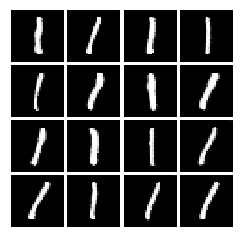

c1 number : 2
c1 : 
 [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]

c2-1 : 
 [[-0.28780009  0.21095426  0.52927539 -0.78001956]
 [ 0.02291996 -0.41063026  0.43089859  0.62598859]
 [ 0.25802697 -0.87723404 -0.73581475 -0.63105293]
 [ 0.64891435 -0.78956172  0.90903102 -0.99954658]]

c2-2 : 
 [[ 0.29702213  0.09363663 -0.65196255 -0.03379128]
 [-0.71781253 -0.95679617 -0.41175516 -0.41138932]
 [-0.77578566 -0.71296649 -0.6559105   0.02492906]
 [ 0.85435514 -0.84673921 -0.50298217  0.63262139]]


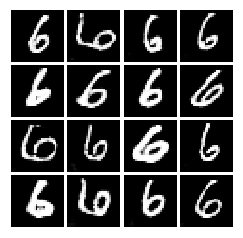

c1 number : 3
c1 : 
 [[2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]]

c2-1 : 
 [[-0.87210646 -0.73152656  0.40203483 -0.50045168]
 [-0.0921643   0.25334921 -0.63501705  0.22583438]
 [-0.82133793  0.31066867 -0.80229993 -0.6830876 ]
 [ 0.07173336  0.7158975   0.37494857  0.36971354]]

c2-2 : 
 [[ 0.07751578  0.99944013  0.30224424  0.71923673]
 [-0.18380309  0.72738106  0.15073594 -0.83327682]
 [-0.45009584  0.79829055 -0.47107973 -0.84180323]
 [ 0.34529227  0.57183948 -0.61638767  0.43695734]]


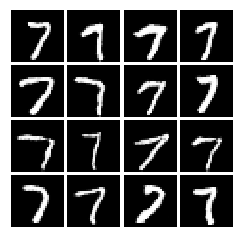

c1 number : 4
c1 : 
 [[3 3 3 3]
 [3 3 3 3]
 [3 3 3 3]
 [3 3 3 3]]

c2-1 : 
 [[ 0.59185121  0.31188372  0.45985126 -0.72395991]
 [ 0.56949991 -0.56949659 -0.7586089  -0.39576718]
 [ 0.73880944  0.01144018 -0.46465591 -0.42088459]
 [ 0.42931031  0.0330043   0.45230617 -0.59856821]]

c2-2 : 
 [[-0.15200808  0.49999385 -0.58507894  0.81026734]
 [-0.58467848  0.46160882 -0.73946359  0.61024431]
 [ 0.94292625  0.35093946  0.20515496 -0.37438585]
 [ 0.05481561  0.15520221 -0.45221764  0.13341783]]


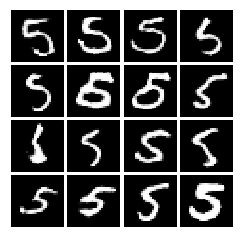

c1 number : 5
c1 : 
 [[4 4 4 4]
 [4 4 4 4]
 [4 4 4 4]
 [4 4 4 4]]

c2-1 : 
 [[ 0.68887048  0.17021391 -0.16439267  0.86574132]
 [ 0.62164474 -0.76296393  0.64824621 -0.29619466]
 [-0.08559237  0.50096285  0.30246412  0.24792974]
 [-0.45517646 -0.56031876 -0.22486227  0.40352292]]

c2-2 : 
 [[-0.20003833 -0.65023785  0.10004225  0.68476946]
 [-0.48304425  0.24547542 -0.05581986  0.9472159 ]
 [-0.57087126  0.3045881   0.20675876 -0.99009174]
 [ 0.12563071 -0.52275421  0.88721167 -0.11070754]]


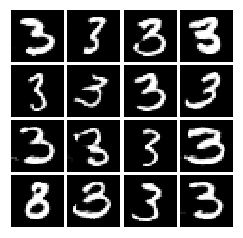

c1 number : 6
c1 : 
 [[5 5 5 5]
 [5 5 5 5]
 [5 5 5 5]
 [5 5 5 5]]

c2-1 : 
 [[ 0.98499045 -0.39669912 -0.20490399 -0.73921052]
 [-0.79751592  0.59372245 -0.80638682 -0.01944591]
 [-0.1277581   0.62257374  0.28660845  0.32395432]
 [ 0.57088548 -0.42426558 -0.87115199 -0.14927136]]

c2-2 : 
 [[  4.36282203e-01  -5.60832131e-04  -4.86414010e-01   4.30488348e-01]
 [ -7.38393879e-01   8.10098270e-01  -9.51295433e-01   2.44450042e-01]
 [ -1.13256102e-01   4.35137860e-01   7.80296461e-01  -9.01498052e-01]
 [  5.56479935e-01  -1.19842727e-01  -5.50427509e-01  -4.60068523e-01]]


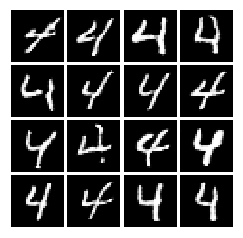

c1 number : 7
c1 : 
 [[6 6 6 6]
 [6 6 6 6]
 [6 6 6 6]
 [6 6 6 6]]

c2-1 : 
 [[-0.10600899  0.97143503 -0.6641069   0.76099093]
 [-0.46472687  0.29365702 -0.80045093 -0.10241972]
 [ 0.0253752  -0.58228781 -0.69174652  0.96095175]
 [-0.49970514 -0.90163279 -0.24214334 -0.15475931]]

c2-2 : 
 [[-0.6422057   0.59186394 -0.8549807  -0.90712169]
 [-0.35009465 -0.63550515  0.87271486 -0.11365887]
 [-0.17765915 -0.29396172 -0.28200853  0.36870841]
 [-0.48116431 -0.95023906  0.79422392  0.97163078]]


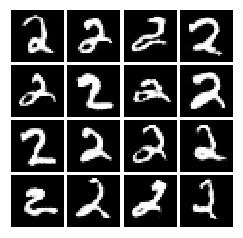

c1 number : 8
c1 : 
 [[7 7 7 7]
 [7 7 7 7]
 [7 7 7 7]
 [7 7 7 7]]

c2-1 : 
 [[ 0.30865234 -0.38147107 -0.09982434  0.68314689]
 [-0.7012738  -0.12697772 -0.06965     0.371129  ]
 [ 0.35588928  0.75935572 -0.39799625 -0.50784446]
 [-0.16877665 -0.346083    0.31268598 -0.61285276]]

c2-2 : 
 [[-0.95130785  0.12748093 -0.60180317  0.99711177]
 [ 0.7510888  -0.49267147  0.37565338  0.56563355]
 [-0.53077488 -0.80464956 -0.61147617  0.9413193 ]
 [-0.36487942  0.2763031   0.28934717 -0.3945197 ]]


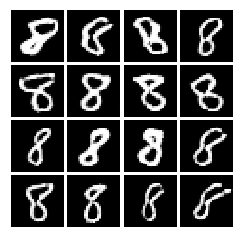

c1 number : 9
c1 : 
 [[8 8 8 8]
 [8 8 8 8]
 [8 8 8 8]
 [8 8 8 8]]

c2-1 : 
 [[ 0.55873035  0.43464552 -0.26115306  0.15774536]
 [-0.80206366 -0.87157209  0.58720795  0.40034186]
 [-0.67956861  0.71617232  0.19507298 -0.8112732 ]
 [ 0.41778347  0.97045194  0.25417551  0.78432105]]

c2-2 : 
 [[-0.29124524  0.18170823  0.40801311  0.11858738]
 [ 0.84731202 -0.41296753 -0.81771739  0.10957434]
 [-0.99970063  0.23477788  0.31768282  0.48272692]
 [-0.18959393 -0.10624307  0.85275498 -0.73282379]]


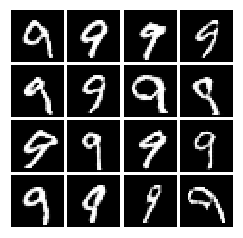

c1 number : 10
c1 : 
 [[9 9 9 9]
 [9 9 9 9]
 [9 9 9 9]
 [9 9 9 9]]

c2-1 : 
 [[ 0.99035076  0.18285122 -0.05809661  0.93875256]
 [-0.83324294 -0.1924116   0.52047508  0.55183826]
 [-0.6576402   0.35452751  0.13901961 -0.09904775]
 [ 0.56819469 -0.96076041  0.18935627 -0.77366642]]

c2-2 : 
 [[-0.76903478  0.73264006  0.10975152  0.03677397]
 [-0.05174936 -0.67621639 -0.14651555  0.48857741]
 [ 0.16589693  0.80969434 -0.96051183 -0.90428837]
 [ 0.45926157 -0.78382839  0.45972895 -0.00890971]]


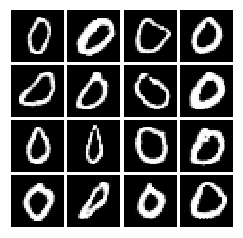

In [23]:
tf.reset_default_graph()

batch_size = 128
dim = 62

z = tf.placeholder(shape = (batch_size, dim), dtype = tf.float32)
c1 = tf.placeholder(shape = (batch_size,10), dtype = tf.float32)
c2 = tf.placeholder(shape = (batch_size,2), dtype = tf.float32)

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])

# generated images
G_sample = generator(tf.concat(axis = 1, values = [z,c1,c2]), is_training = False)

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, r"C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN_gpu\infoGAN_ex.ckpt")
    print("model retored")
    for i in range(10) :
        noise_z = sample_noise(128, 62)
        sam_c2 = sample_c2((128))
        sam_c1 = np.zeros((128,10))
        sam_c1[:,i] = 1.0
        print("c1 number : %d" %(i+1))
        samples = sess.run(G_sample, feed_dict = {z : noise_z, c1 : sam_c1, c2 : sam_c2})
        fig = show_images(samples[:16], sam_c1[:16], sam_c2[:16])
        plt.show()    

INFO:tensorflow:Restoring parameters from C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN_gpu\infoGAN_ex2.ckpt
model retored
c1 number : 1
c1 : 
 [[7 4 7 3]
 [3 1 2 5]
 [4 5 7 8]
 [3 0 6 9]]

c2-1 : 
 [[-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]]

c2-2 : 
 [[ 0.5  -0.57 -0.86  0.09]
 [-0.7  -0.69  1.    0.21]
 [ 0.6  -0.91 -0.37 -0.3 ]
 [ 0.1   0.71 -0.02 -0.62]]


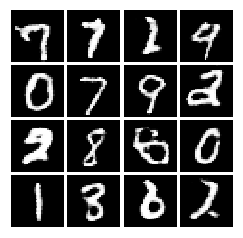

c1 number : 2
c1 : 
 [[1 3 3 9]
 [2 7 4 8]
 [0 9 5 8]
 [8 1 8 9]]

c2-1 : 
 [[-0.78 -0.78 -0.78 -0.78]
 [-0.78 -0.78 -0.78 -0.78]
 [-0.78 -0.78 -0.78 -0.78]
 [-0.78 -0.78 -0.78 -0.78]]

c2-2 : 
 [[ 0.58 -0.97  0.75  0.36]
 [-0.61 -0.12 -0.51 -0.85]
 [ 0.54 -0.82 -0.66 -0.33]
 [ 0.5  -0.73  0.15 -0.2 ]]


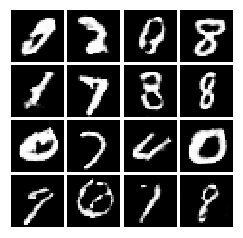

c1 number : 3
c1 : 
 [[6 9 6 9]
 [5 6 5 3]
 [8 9 5 3]
 [5 1 0 6]]

c2-1 : 
 [[-0.56 -0.56 -0.56 -0.56]
 [-0.56 -0.56 -0.56 -0.56]
 [-0.56 -0.56 -0.56 -0.56]
 [-0.56 -0.56 -0.56 -0.56]]

c2-2 : 
 [[-0.87  0.53  0.81 -0.61]
 [ 0.94  0.73  0.86 -0.08]
 [ 0.9   0.92  0.59  0.55]
 [ 0.75 -0.27 -0.9   0.64]]


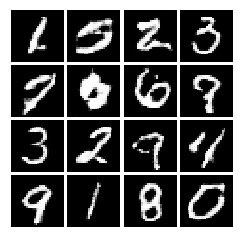

c1 number : 4
c1 : 
 [[6 7 8 4]
 [0 9 5 7]
 [5 2 4 2]
 [9 4 1 3]]

c2-1 : 
 [[-0.33 -0.33 -0.33 -0.33]
 [-0.33 -0.33 -0.33 -0.33]
 [-0.33 -0.33 -0.33 -0.33]
 [-0.33 -0.33 -0.33 -0.33]]

c2-2 : 
 [[-0.02 -0.56  0.85  0.71]
 [-0.25  0.27  0.85 -0.35]
 [-0.69  0.01 -0.58  0.6 ]
 [-0.66 -0.54 -0.17 -0.18]]


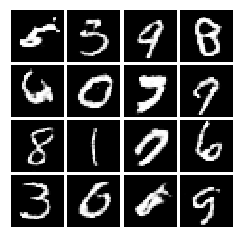

c1 number : 5
c1 : 
 [[8 5 9 8]
 [6 8 0 3]
 [6 7 8 0]
 [0 7 5 8]]

c2-1 : 
 [[-0.11 -0.11 -0.11 -0.11]
 [-0.11 -0.11 -0.11 -0.11]
 [-0.11 -0.11 -0.11 -0.11]
 [-0.11 -0.11 -0.11 -0.11]]

c2-2 : 
 [[ 0.05 -0.96  0.99 -0.27]
 [ 0.83  0.52  0.16 -0.14]
 [-0.76  0.87  0.19 -0.6 ]
 [ 0.25 -0.99  0.3   0.16]]


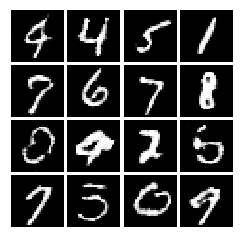

c1 number : 6
c1 : 
 [[7 2 4 8]
 [9 6 2 0]
 [5 0 5 2]
 [9 0 3 7]]

c2-1 : 
 [[ 0.11  0.11  0.11  0.11]
 [ 0.11  0.11  0.11  0.11]
 [ 0.11  0.11  0.11  0.11]
 [ 0.11  0.11  0.11  0.11]]

c2-2 : 
 [[ -1.81e-01  -9.24e-01   2.37e-01   6.33e-01]
 [ -3.65e-01  -7.08e-01  -1.55e-01   2.42e-01]
 [  5.38e-02  -8.69e-04  -5.84e-02  -7.60e-01]
 [  8.64e-01  -4.56e-01  -1.81e-01   3.74e-01]]


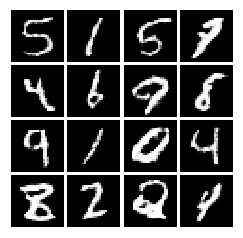

c1 number : 7
c1 : 
 [[2 8 4 7]
 [9 3 1 7]
 [8 9 6 3]
 [2 4 7 8]]

c2-1 : 
 [[ 0.33  0.33  0.33  0.33]
 [ 0.33  0.33  0.33  0.33]
 [ 0.33  0.33  0.33  0.33]
 [ 0.33  0.33  0.33  0.33]]

c2-2 : 
 [[-0.85  0.06  0.22 -0.26]
 [-0.2   0.75 -0.59 -0.64]
 [-0.28 -0.37  0.21  0.82]
 [ 0.25 -0.37 -0.33  0.5 ]]


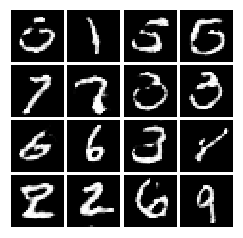

c1 number : 8
c1 : 
 [[4 4 8 7]
 [6 9 7 1]
 [0 7 8 4]
 [1 7 5 2]]

c2-1 : 
 [[ 0.56  0.56  0.56  0.56]
 [ 0.56  0.56  0.56  0.56]
 [ 0.56  0.56  0.56  0.56]
 [ 0.56  0.56  0.56  0.56]]

c2-2 : 
 [[-0.2  -0.1   0.79 -0.44]
 [ 0.81  0.43  0.9  -0.7 ]
 [-0.83  0.24 -0.71 -0.68]
 [-0.17  0.32 -0.28  0.87]]


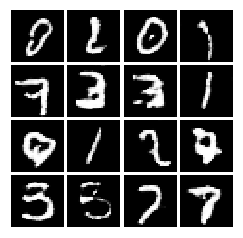

c1 number : 9
c1 : 
 [[2 8 8 4]
 [8 7 4 3]
 [0 8 5 8]
 [8 3 3 1]]

c2-1 : 
 [[ 0.78  0.78  0.78  0.78]
 [ 0.78  0.78  0.78  0.78]
 [ 0.78  0.78  0.78  0.78]
 [ 0.78  0.78  0.78  0.78]]

c2-2 : 
 [[-0.95 -0.12  0.88 -0.81]
 [ 0.69 -0.89  0.11  0.77]
 [-0.25 -0.25 -0.29  0.9 ]
 [-0.32 -0.47  0.14 -0.56]]


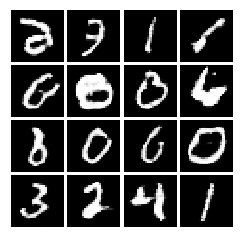

c1 number : 10
c1 : 
 [[8 4 4 6]
 [1 6 9 7]
 [2 3 2 6]
 [8 5 1 5]]

c2-1 : 
 [[ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]]

c2-2 : 
 [[-0.45  0.92  0.5   0.95]
 [ 0.09 -0.06 -0.68  0.66]
 [-0.2  -0.96  0.71 -0.87]
 [-0.38  0.49  0.84  0.53]]


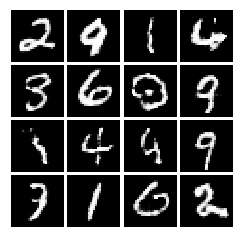

In [30]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, r"C:\Users\LG\Documents\CNN\assignment2\tensorflow\infoGAN_gpu\infoGAN_ex2.ckpt")
    print("model retored")
    for i in range(10) :
        noise_z = sample_noise(128, 62)
        sam_c2 = sample_c2((128))
        sam_c1 = sample_c1((128))
        sam_c2[:16][:,0] = [np.linspace(-1,1,10)[i]]*16
        print("c1 number : %d" %(i+1))
        samples = sess.run(G_sample, feed_dict = {z : noise_z, c1 : sam_c1, c2 : sam_c2})
        fig = show_images(samples[:16], sam_c1[:16], sam_c2[:16])
        plt.show()    

In [116]:
# 호출할때마다 c2가 생성됨 => generator 에 쓰이는 c2 출력 못함
# c1의 경우에는 numpy로 불러내어 처음 그래프 그릴 때만 한번 호출되어 iter돌릴떄 값이 안변함
tf.reset_default_graph()


def first_(c2):
    return (c2[0])

batch_size = 1
c2 = tf.placeholder(shape = [1,1], dtype = tf.float32)
z = sample_noise(batch_size,1)
x = mean_(c2)
y = first_(z)

with tf.Session() as sess:
    c1 = sample_c2(batch_size)
    print("numpy : ", sess.run(x,feed_dict = {c2 : c1}))
    print("tensor : ", sess.run(y))
    print("")
    print("numpy array is saved but tensor is called each time you run")
    print("numpy : ", sess.run(x,feed_dict = {c2 : c1}))
    print("tensor :", sess.run(y))
    
    print("")
    print("you can recall numpy to change value")
    c1 = sample_c2(batch_size)
    print("numpy : ", sess.run(c2, feed_dict = {c2 : c1}))
    print("tensor : ", sess.run(y))

numpy :  [[ 0.35773465]]
tensor :  [ 0.25076842]

numpy array is saved but tensor is called each time you run
numpy :  [[ 0.35773465]]
tensor : [-0.007828]

you can recall numpy to change value
numpy :  [[ 0.95157939]]
tensor :  [-0.40913701]


In [19]:
import tensorflow as tf

tf.reset_default_graph()

a = tf.placeholder(shape = [None, 2], dtype = tf.float32)
b = tf.placeholder(shape = [None, 3], dtype = tf.float32)
c = a**2
d = tf.gradients(c,a)
e = tf.reduce_max(d,axis = 1)

with tf.Session() as sess:
    print(sess.run(d, feed_dict={a:[[1,2],[3,3]]}))

[array([[ 2.,  4.],
       [ 6.,  6.]], dtype=float32)]
